In [22]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [7]:
#Get 2015 (most recent available) IRS return data by zip code and create dataframe
donor_raw = pd.read_csv("https://www.irs.gov/pub/irs-soi/15zpallagi.csv")
donor_raw.head()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,PREP,N2,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,1,836320.0,481570.0,109790.0,233260.0,455560.0,1356760.0,...,373410.0,328469.0,0.0,0.0,0.0,0.0,61920.0,48150.0,732670.0,1933120.0
1,1,AL,0,2,494830.0,206630.0,146250.0,129390.0,275920.0,1010990.0,...,395880.0,965011.0,0.0,0.0,0.0,0.0,73720.0,107304.0,415410.0,1187403.0
2,1,AL,0,3,261250.0,80720.0,139280.0,36130.0,155100.0,583910.0,...,251490.0,1333418.0,0.0,0.0,0.0,0.0,64200.0,139598.0,193030.0,536699.0
3,1,AL,0,4,166690.0,28510.0,124650.0,10630.0,99950.0,423990.0,...,165320.0,1414283.0,0.0,0.0,0.0,0.0,45460.0,128823.0,116440.0,377177.0
4,1,AL,0,5,212660.0,19520.0,184320.0,4830.0,126860.0,589490.0,...,212000.0,3820152.0,420.0,168.0,60.0,31.0,83330.0,421004.0,121570.0,483682.0


In [44]:
#Check the number of imported records
donor_raw.zipcode.shape[0]

166698

In [32]:
with open('mta_zip_unique.pickle','rb') as read_file:
    new_mta_zip = pickle.load(read_file)
new_mta_zip.head()

,LAT,LON,STATION,zipcode
378,0.551045,-74.1514904,NELSON AV & BROWER ST AT NE CORNER,83010
53,0.688157,-73.965579,WASHINGTON AVE & LAFAYETTE AVE AT SE CORNER,82010
1096,40.583369,-73.827474,BEACH 106TH ST & ROCKAWAY FRWY AT SW CORNER,11694
1077,40.588080,-73.813907,BEACH 89TH ST & ROCKAWAY FRWY AT NW CORNER,11693
1079,40.590744,-73.797789,BEACH 67TH ST & ROCKAWAY FRWY AT NW CORNER,11692


In [33]:
#Check the number of imported zip codes
new_mta_zip.shape[0]

139

In [13]:
donor_zip = pd.DataFrame.merge(donor_raw,new_mta_zip,on="zipcode")

In [17]:
donor_zip = donor_zip[["zipcode","agi_stub","N02650","A02650","N19700","A19700"]]
donor_zip.head()

,zipcode,agi_stub,N02650,A02650,N19700,A19700
0,10001,1,3760.0,44588.0,200.0,288.0
1,10001,2,2430.0,92506.0,380.0,804.0
2,10001,3,1930.0,121893.0,580.0,1145.0
3,10001,4,1340.0,117209.0,720.0,1391.0
4,10001,5,2480.0,353017.0,1520.0,3537.0


In [19]:
donor_sum = donor_zip.groupby(by = ["zipcode"])[["N02650","A02650","N19700","A19700"]].sum()
donor_sum.head()

,N02650,A02650,N19700,A19700
zipcode,,,,
10001,14310.0,2402685.0,5230.0,34731.0
10002,43190.0,2334694.0,6970.0,21115.0
10003,30050.0,7562151.0,14180.0,134500.0
10004,2490.0,1018420.0,1250.0,20318.0
10005,6160.0,3812495.0,2700.0,198932.0


In [30]:
#Check number of zip codes in summarized data
donor_sum.shape[0]

131

In [20]:
donor_sum["PCT_DONORS"] = donor_sum["N19700"] / donor_sum["N02650"]
donor_sum["PCT_INCOME"] = donor_sum["A19700"] / donor_sum["A02650"]
donor_sum.head()

,N02650,A02650,N19700,A19700,PCT_DONORS,PCT_INCOME
zipcode,,,,,,
10001,14310.0,2402685.0,5230.0,34731.0,0.365479,0.014455
10002,43190.0,2334694.0,6970.0,21115.0,0.161380,0.009044
10003,30050.0,7562151.0,14180.0,134500.0,0.471880,0.017786
10004,2490.0,1018420.0,1250.0,20318.0,0.502008,0.019951
10005,6160.0,3812495.0,2700.0,198932.0,0.438312,0.052179


In [24]:
donor_sum["PCT_DONORS"].describe()

count    131.000000
mean       0.279006
std        0.137800
min        0.074074
25%        0.168701
50%        0.233610
75%        0.381573
max        0.603604
Name: PCT_DONORS, dtype: float64

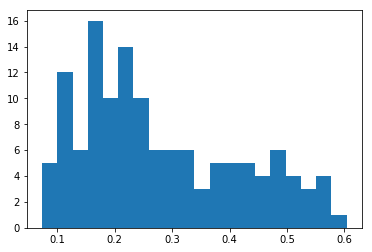

In [41]:
plt.hist(donor_sum["PCT_DONORS"], bins=20);

In [49]:
#Select zip codes where 38.2%+ individuals donate to charity (75th percentile)
donor_target_zips = donor_sum.loc[donor_sum["PCT_DONORS"] > 0.381573]
donor_target_zips.shape[0]

33

In [50]:
#Remove unnecessary columns for target file 
donor_target_zips = donor_target_zips.drop(["N02650", "A02650", "N19700", "A19700", "PCT_INCOME"], axis=1, errors="ignore")
donor_target_zips.head()

,PCT_DONORS
zipcode,
10003,0.471880
10004,0.502008
10005,0.438312
10006,0.411523
10007,0.603604


In [53]:
#Create file for use with final target selection
with open('donor_target_zips.pickle', 'wb') as to_write:
    pickle.dump(donor_target_zips, to_write)

In [55]:
#Output donor data for heatmap
donor_map = donor_sum.drop(["N02650", "A02650", "N19700", "A19700", "PCT_INCOME"], axis=1, errors="ignore")
donor_map.to_csv(r"C:\Users\jphos\Documents\Metis\donor_data_map.csv", sep=',', encoding='utf-8')